# Pebble drift past the CO ice line in protoplanetary discs

### Course project for *Reproducible and Interactive Data Analysis and Modelling using Jupyter Notebooks* VT20

This Notebook reproduces (preliminary) results of the manuscript in preparation "Pebble drift past the CO ice line in protoplanetary discs", K. Ros & A. Johansen, to be submitted to *Astronomy & Astrophysics*.

### Instructions for running the notebook

Before running this notebook, the following steps should be taken.

1. Install [Miniconda](https://docs.conda.io/en/latest/miniconda.html)/[Anaconda](https://docs.anaconda.com/anaconda/install/).

2. Download the files from this GitHub repository

3. In the terminal, navigate to the folder you downloaded from GitHub

4. Create the environment
    - The file katrin_environment.yml in this folder contains the required packages.
    - To use this environment type the following into your terminal
	```
	conda env create -f katrin_environment.yml
	```
5. Now activate the environment by typing 
	```
	conda activate katrin_environment
	```
6. Run the notebook by typing
	```
	jupyter notebook
	```

Once this is all done, you are ready to move on to the notebook itself. Please make sure that all cells are executed in order to make things go smoothly!


### Abstract of project

Planets are born in discs of gas and dust surrounding young stars. Studying the distribution and dynamics of this planet-forming material is important in order to understand how and where planets form. 

In this project we study the dynamics of a fundamental building block of planets; icy, millimetre-sized *pebbles* that are observed in discs and are thought to be necessary for the further growth of planet-sized bodies. We focus on these pebbles at a specific location in the disc, namely the *CO ice line*, the distance from the central star where CO gas freezes out on icy dust and pebbles, and conversely where the frozen CO on inwards-drifting pebbles sublimates and leaves behind a pile-up of CO vapour.

In this notebook we analyze data obtained from numerical simulations with the PLANETESYS code, in which we have modelled the gas and ice in such a protoplanetary disc. We follow four different components in the disc: silicate pebbles, and water, CO2, and CO vapour and ice. In our model we have implemented dynamics of gas and solids in the disc, and also sublimation and condensation of the included volatiles. 

We first look at the dynamics of the gas and pebble components of the disc, and thereafter we move on to show that there is a resulting pile-up of CO vapour around the ice line. This pile-up is an important observable signature of the ice line, and allows for comparisons between observations and theoretical models. 


### Import the packages we need in this notebook

In [1]:
#import packages we need
# for data manipulation:
import numpy as np
# for using idl data: 
import scipy.io
#for plotting:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### Define constants 

In [11]:
au = 1.496e11 # 1 astronomical unit (Earth-Sun distance)in meters
yr = (60.*60.*24.*365.) # 1 year in seconds

### Specify variables
We now need to specify how many times we have datasets for (default ntimes=4), the inner edge of the simulation domain (default r_in=1 au), the outer edge of the simulation domain (default r_out=100 au) and the grid cell size over which the column density is calculated (default dr=1au). Dr can be set smaller, but this will cause the computation to be much slower.

In [13]:
# variables that should be specified

ntimes=4 # n of times we have datasets for
r_in=1*au # inner edge of simulation domain
r_out=100*au # outer edge of simulation domain
dr=1*au # grid cell size for sigma

From these variables we calculate the number of grid cells for calculation of column density below.

In [14]:
# calculates n of grid cells for sigma
n_gc=int((r_out-r_in)/dr)

### Read in and manipulate data

Now we are going to read in the data in form av snapshots in time. The data is from PLANETESYS simulations from which it has been read out with an IDL script and saved as an IDL .sav file. We import the data using scipy.io.readsav. 

Once the data is imported we extract the arrays we need to plot gas and particle velocities, and to calculate the CO column density. The column density is also calculated in this next cell.

In [10]:
for i in range(0,ntimes):

    # initiates arrays for calculating sigma
    mv_co=np.zeros(n_gc) # CO vapour mass in grid cell
    mp_co=np.zeros(n_gc) # CO solid mass in grid cell
    r=np.zeros(n_gc) # radial position of grid cell
    sigmav=np.zeros(n_gc) # Sigma CO vapour
    sigmap=np.zeros(n_gc) #Sigma CO solid

    # import idl data as dictionary    
    if i==0:
        fp=scipy.io.readsav('data/fp0.dat')
        ff=scipy.io.readsav('data/ff0.dat')
    elif i==1:
        fp=scipy.io.readsav('data/fp1.dat')
        ff=scipy.io.readsav('data/ff1.dat') 
    elif i==2:
        fp=scipy.io.readsav('data/fp10.dat')
        ff=scipy.io.readsav('data/ff10.dat')            
    else:    
        fp=scipy.io.readsav('data/fp100.dat')
        ff=scipy.io.readsav('data/ff100.dat')  

    ## to read out what data there is in fp (or ff)    
    #print('list data', fp['fp'].dtype.names)
    #print(var=fp['fp'].var.item())  #replace var with a variable name   

    ## --- particle velocity --- ## 
    
    # particle position
    xx=fp['fp'].xx.item() # particle positions
    x=(xx[0,:]) # xpos of particles
    # particle velocity
    vv=fp['fp'].vv.item() # particle velocities
    v=(vv[0,:]) # xvel of particles
    # particle radius
    a=fp['fp'].a.item() # particle radius

    # solid indexes
    s_ind=np.nonzero(a)[0]
    a_sol=a[s_ind] # radii of all solid particles
    x_sol=x[s_ind]
    v_sol=v[s_ind]

    ## --- gas velocity --- ##
    
    # gas position
    xg=ff['ff'].x.item() # gas position
    # gas velocity 
    vvg=ff['ff'].uu.item() #gas velocity
    # extract x from vel 
    vg=(vvg[0,:]) # xvel of gas
    
    # remove the outer cells w non-physical data
    xg=xg[3:-4]
    vg=vg[3:-4]
    
    ## --- additionaly for calculating sigma --- ##
    
    mpswarm=fp['fp'].mpswarm.item() # mass in swarm
    fco=fp['fp'].fco.item() # co mass fraction of particle
    npar=fp['fp'].npar_found.item()
    
    ## --- calculate sigma --- ##
    
    for ip in range(0, npar):
        for gc in range(0,n_gc):
            rmin=r_in+gc*dr
            rmax=rmin+dr
            if (ip==0):
                r[gc]=r_in+gc*dr
            if ((x[ip]>rmin) and (x[ip]<rmax)):
                if (a[ip]>0):
                    mp_co[gc]=mp_co[gc]+mpswarm[ip]*fco[ip]
                else:
                    mv_co[gc]=mv_co[gc]=mv_co[gc]+mpswarm[ip]*fco[ip]
    # calculate vapour column density (sigmav) and solid column density (sigmap)
    sigmav=(mv_co*1000.)/(2*np.pi*r*100.*dr*100.)
    sigmap=(mp_co*1000.)/(2*np.pi*r*100.*dr*100.)
    
    # save data for plotting   
    if i==0:
        x_sol0=x_sol
        v_sol0=v_sol
        xg0=xg
        vg0=vg
        sigmav0=sigmav
        sigmap0=sigmap
    elif i==1:
        x_sol1=x_sol
        v_sol1=v_sol
        xg1=xg
        vg1=vg
        sigmav1=sigmav
        sigmap1=sigmap
    elif i==2:
        x_sol10=x_sol
        v_sol10=v_sol 
        xg10=xg
        vg10=vg
        sigmav10=sigmav
        sigmap10=sigmap        
    else:    
        x_sol100=x_sol
        v_sol100=v_sol 
        xg100=xg
        vg100=vg
        sigmav100=sigmav
        sigmap100=sigmap

### Comparing pebble velocity and gas velocity

The possible pile-up of CO gas inside the ice line is connected to the pebble drift velocity inwards through the disc compared to the gas disc expansion. Below we plot the pebble drift velocity and the gas velocity.

Without turbulence all pebbles drift inwards, and in this simulation we do not have a resupply of solids in the outer part of the disc. The disc is thus drained of pebbles after a little more than 1 Myr. The gas disc on the other hand is expanding, through outwards-moving gas everywhere outside of 20-30 au. It is the interplay between the dynamics of these two disc components that sets whether or not we get a significant overdensity of gas and/or solids at the CO ice line.

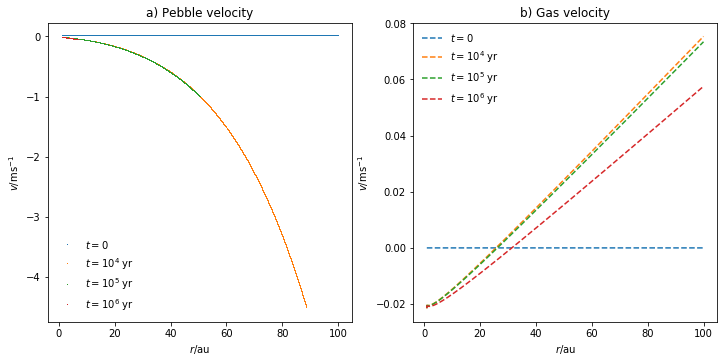

In [12]:
#fig = plt.figure(figsize=(18/2.54,8/2.54))
fig = plt.figure(figsize=(12,5.5))
psym1=','
psym2='--'
fst='12'
fs='10'

# first subplot
ax = fig.add_subplot(1,2,1) 
plt.plot(x_sol0/au, v_sol0, psym1, label='$t=0$')
plt.plot(x_sol1/au, v_sol1, psym1, label='$t=10^4$ yr')
plt.plot(x_sol10/au, v_sol10, psym1, label='$t=10^5$ yr')
plt.plot(x_sol100/au, v_sol100, psym1, label='$t=10^6$ yr')

plt.title('a) Pebble velocity', fontsize=fst)
plt.xlabel('$r / \mathrm{au}$', fontsize=fs)
plt.ylabel('$v/\mathrm{ms^{-1}}$', fontsize=fs)
plt.legend(handlelength=2, frameon=False)

# second subplot
ax = fig.add_subplot(1,2,2) 
plt.plot(xg0/au,vg0, psym2, label='$t=0$')
plt.plot(xg1/au,vg1, psym2, label='$t=10^4$ yr')
plt.plot(xg10/au,vg10, psym2, label='$t=10^5$ yr')
plt.plot(xg100/au,vg100, psym2, label='$t=10^6$ yr')

plt.title('b) Gas velocity', fontsize=fst)
plt.xlabel('$r / \mathrm{au}$', fontsize=fs)
plt.ylabel('$v/\mathrm{ms^{-1}}$', fontsize=fs)

plt.legend(handlelength=2, frameon=False)

#plt.show() 
plt.savefig("velocities.png",dpi=300, bbox_inches="tight");

### Column density of CO vapour and ice

Below we plot the column densities of CO vapour and ice. The CO ice line can be seen as the location where vapour is piling up, and the inner edge of solid CO ice. After 100 000 years all pebbles have drifted past the CO ice line and we do not find any solid CO in the disc.

We see a significant overdensity of CO vapour at the CO ice line at 40 au. With vapour column densities rising with a factor 2-5, this can be used as an observational probe of the ice line and inwards pebble drift and sublimation.

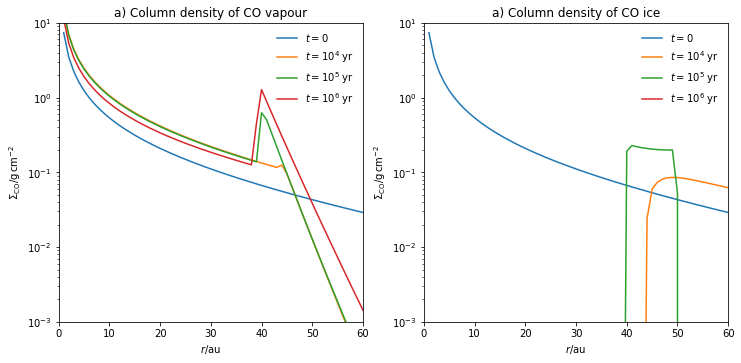

In [91]:
fig = plt.figure(figsize=(12,5.5))

#psym1='-'
#psym2='--'
fst='12'
fs='10'

# first subplot
ax = fig.add_subplot(1,2,1) 
#ax.set(xlabel='$r / \mathrm{au}$', ylabel='$v/\mathrm{ms^{-1}}$', title='Pebble velocity');
plt.plot(r/au, sigmav0, label='$t=0$')
plt.plot(r/au, sigmav1, label='$t=10^4$ yr')
plt.plot(r/au, sigmav10, label='$t=10^5$ yr')
plt.plot(r/au, sigmav100, label='$t=10^6$ yr')

plt.yscale('log')
plt.xlim(0,60)
plt.ylim(0.001,10)
plt.ylim
plt.title('a) Column density of CO vapour', fontsize=fst)
plt.xlabel('$r / \mathrm{au}$', fontsize=fs)
plt.ylabel('$\Sigma_\mathrm{CO}/\mathrm{g\, cm^{-2}}$', fontsize=fs)
plt.legend(handlelength=2, frameon=False)


# second subplot
ax = fig.add_subplot(1,2,2) 
#ax.set(xlabel='$r / \mathrm{au}$', ylabel='$v/\mathrm{ms^{-1}}$', title='Pebble velocity');
plt.plot(r/au, sigmap0, label='$t=0$')
plt.plot(r/au, sigmap1, label='$t=10^4$ yr')
plt.plot(r/au, sigmap10, label='$t=10^5$ yr')
plt.plot(r/au, sigmap100, label='$t=10^6$ yr')

plt.yscale('log')
plt.xlim(0,60)
plt.ylim(0.001,10)
plt.ylim
plt.title('b) Column density of CO ice', fontsize=fst)
plt.xlabel('$r / \mathrm{au}$', fontsize=fs)
plt.ylabel('$\Sigma_\mathrm{CO}/\mathrm{g\, cm^{-2}}$', fontsize=fs)
plt.legend(handlelength=2, frameon=False)

#plt.show()
plt.savefig("sigma.png",dpi=300, bbox_inches="tight");